# Imports

In [1]:
import numpy as np
import random
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch
from torch.utils.data import DataLoader
from torchmetrics.classification import AUROC, Accuracy
from sklearn.metrics import f1_score, roc_curve, auc, precision_recall_curve,\
                            average_precision_score, accuracy_score, f1_score,\
                            precision_score, recall_score, classification_report
import os
from sklearn.model_selection import train_test_split
import shutil
from copy import deepcopy
from tqdm import tqdm
from matplotlib import pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Global settings

In [2]:
from torchvision.models.resnet import resnet152 as Model
from torchvision.models.resnet import ResNet152_Weights as ModelW
OPTIM_PARAMS = {"lr":1e-5}
OPTIM = torch.optim.AdamW
CRITERIUM = torch.nn.CrossEntropyLoss
BATCH_SIZE = 16
IMAGE_SIZE = 256
N_EPOCHS = 30
PATIENCE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = 2 if DEVICE=='cuda' else 4 # fixed by kaggle notebook
SEED = 42

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Data split load

In [3]:
%%capture
!cp -r /kaggle/input/brain-tumors-256x256/Data /kaggle/working/Data

In [4]:
data_dir = '/kaggle/working/Data'
output_dir = '/kaggle/working/'

train_percent = 0.7
val_percent = 0.1
test_percent = 0.2

for root, dirs, files in os.walk(data_dir):
    if len(files) > 0:
        train_files, temp_files = train_test_split(files, test_size=(1 - train_percent), random_state=SEED)
        val_files, test_files = train_test_split(temp_files, test_size=(test_percent / (test_percent + val_percent)), random_state=SEED)
        for split_name,files in zip(["train","val","test"],[train_files,val_files,test_files]):
            new_output_dir = os.path.join(output_dir, split_name, os.path.relpath(root, data_dir))
            os.makedirs(new_output_dir, exist_ok=True)
            #print(new_output_dir)
            for file in files:
                src = os.path.join(root, file)
                dst = os.path.join(new_output_dir, file)
                shutil.move(src, dst)


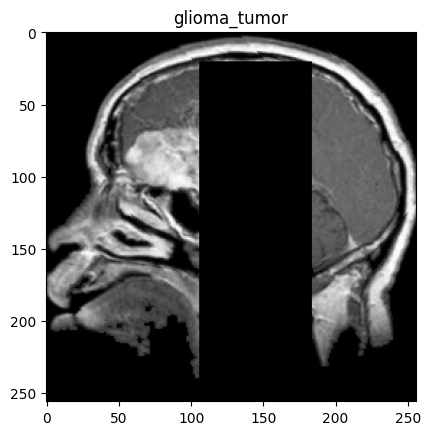

In [5]:
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomAffine(5,translate=[0,.1],scale=[.9,1.1]),
                                      transforms.ToTensor(),
                                      transforms.RandomErasing(),
                                     ])

transform_val = transforms.Compose([transforms.ToTensor(),
                                   ])

train = ImageFolder("train",
                    transform=transform_train,
                   )

val = ImageFolder("val",
                    transform=transform_val,
                   )

test = ImageFolder("test",
                    transform=transform_val,
                   )

class_names = train.classes

plt.imshow(train[0][0].transpose(0,2).transpose(1,0))
plt.title(train.classes[train[0][1]])
plt.show()

In [6]:
# loaders :
train_loader = DataLoader(train,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=True,drop_last=True)
val_loader = DataLoader(val,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=False,drop_last=False)
test_loader = DataLoader(test,batch_size=BATCH_SIZE,num_workers=NUM_WORKERS,shuffle=False,drop_last=False)

# Model

In [7]:
model = Model(weights=ModelW.IMAGENET1K_V1)
model.fc = torch.nn.Linear(in_features=model.fc.in_features,out_features=4)
model(torch.randn((BATCH_SIZE,3,IMAGE_SIZE,IMAGE_SIZE))).shape

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:00<00:00, 254MB/s]


torch.Size([16, 4])

# Train

In [8]:
model.to(DEVICE)

optimizer = OPTIM(model.parameters(),**OPTIM_PARAMS)
criterium = CRITERIUM()

best_model = deepcopy(model)
best_acc = 0
patience = 0

for epoch in range(N_EPOCHS):
    train_loss = 0
    train_total = 0
    model.train()
    for x,y in tqdm(train_loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        output = model(x)
        loss = criterium(output,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
        train_total += x.size(0)
    train_loss /= train_total
    
    val_loss = 0
    val_total = 0
    val_acc = 0
    model.eval()
    with torch.no_grad():
        for x,y in val_loader:
            x = x.to(DEVICE)
            y = y.to(DEVICE)
            output = model(x)
            loss = criterium(output,y)
            val_loss += loss.item() * x.size(0)
            val_total += x.size(0)
            val_acc += torch.sum(torch.argmax(output,dim=-1)==y).item()
    val_loss /= val_total
    val_acc /= val_total

    
    # save
    if val_acc > best_acc :
        best_acc = val_acc
        best_model = deepcopy(model)
        patience = 0
    else :
        patience += 1
    
    print("Epoch {} : train loss {:.4f} | val loss {:.4f} | val Acc {:.2f}".format(epoch,
                                                                                   train_loss,
                                                                                   val_loss,
                                                                                   val_acc))
    
    # earlystopping
    if patience >= PATIENCE :
        break

100%|██████████| 135/135 [00:41<00:00,  3.22it/s]


Epoch 0 : train loss 0.9484 | val loss 0.4695 | val Acc 0.85


100%|██████████| 135/135 [00:36<00:00,  3.74it/s]


Epoch 1 : train loss 0.5244 | val loss 0.2736 | val Acc 0.92


100%|██████████| 135/135 [00:35<00:00,  3.76it/s]


Epoch 2 : train loss 0.3823 | val loss 0.2084 | val Acc 0.94


100%|██████████| 135/135 [00:36<00:00,  3.74it/s]


Epoch 3 : train loss 0.3188 | val loss 0.1859 | val Acc 0.94


100%|██████████| 135/135 [00:35<00:00,  3.75it/s]


Epoch 4 : train loss 0.2657 | val loss 0.1607 | val Acc 0.94


100%|██████████| 135/135 [00:35<00:00,  3.77it/s]


Epoch 5 : train loss 0.2410 | val loss 0.1639 | val Acc 0.95


100%|██████████| 135/135 [00:35<00:00,  3.77it/s]


Epoch 6 : train loss 0.1913 | val loss 0.1761 | val Acc 0.94


100%|██████████| 135/135 [00:36<00:00,  3.74it/s]


Epoch 7 : train loss 0.1704 | val loss 0.1671 | val Acc 0.95


100%|██████████| 135/135 [00:36<00:00,  3.74it/s]


Epoch 8 : train loss 0.1709 | val loss 0.1598 | val Acc 0.95


100%|██████████| 135/135 [00:35<00:00,  3.77it/s]


Epoch 9 : train loss 0.1563 | val loss 0.1343 | val Acc 0.96


100%|██████████| 135/135 [00:35<00:00,  3.78it/s]


Epoch 10 : train loss 0.1619 | val loss 0.1462 | val Acc 0.95


100%|██████████| 135/135 [00:35<00:00,  3.77it/s]


Epoch 11 : train loss 0.1471 | val loss 0.1371 | val Acc 0.96


100%|██████████| 135/135 [00:36<00:00,  3.75it/s]


Epoch 12 : train loss 0.1352 | val loss 0.1385 | val Acc 0.95


100%|██████████| 135/135 [00:36<00:00,  3.74it/s]


Epoch 13 : train loss 0.1258 | val loss 0.1412 | val Acc 0.96


# Graphs

In [9]:
y_true, y_pred = [], []
model = best_model
model.eval()
with torch.no_grad():
    for x,y in tqdm(test_loader):
        x = x.to(DEVICE)
        y = y.to(DEVICE)
        output = model(x).softmax(dim=-1)
        y_true.extend(y.cpu().numpy())
        y_pred.extend(output.cpu().numpy())
y_pred = np.array(y_pred)
y_true = np.array(y_true)

100%|██████████| 39/39 [00:03<00:00, 10.72it/s]


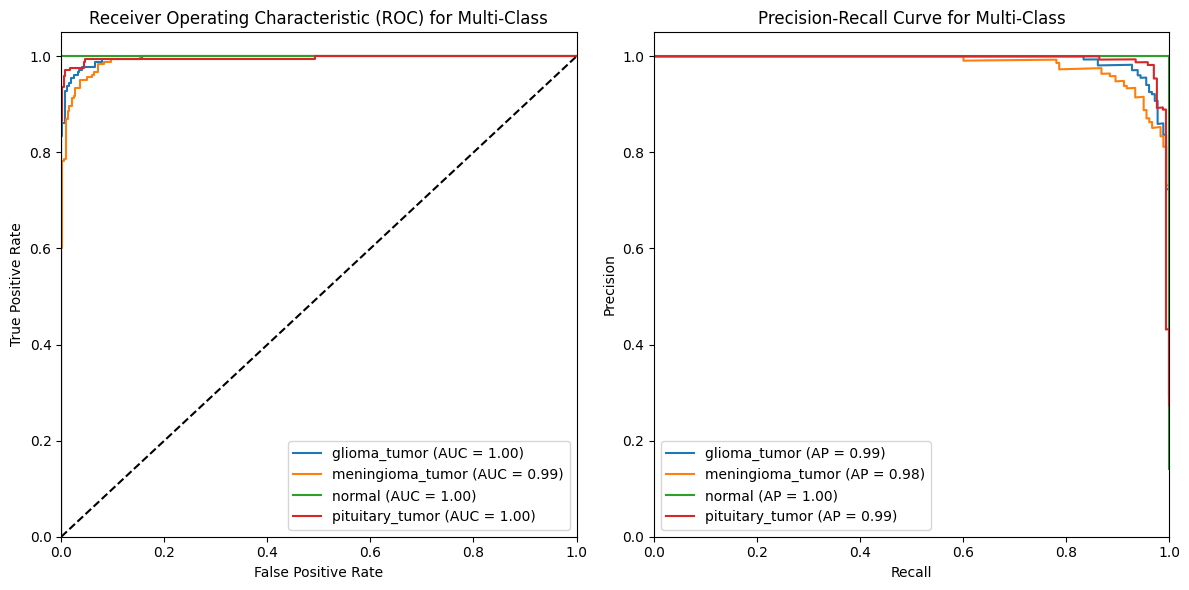

In [10]:
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()
precision = dict()
recall = dict()
average_precision = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    precision[i], recall[i], _ = precision_recall_curve(y_true == i, y_pred[:, i])
    average_precision[i] = average_precision_score(y_true == i, y_pred[:, i])

plt.figure(figsize=(12, 6))
for i in range(n_classes):
    plt.subplot(1, 2, 1)
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:0.2f})')
    
for i in range(n_classes):
    plt.subplot(1, 2, 2)
    plt.plot(recall[i], precision[i], label=f'{class_names[i]} (AP = {average_precision[i]:0.2f})')

plt.subplot(1, 2, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for Multi-Class')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Multi-Class')
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

# Metrics

In [11]:
y_pred_labels = y_pred.argmax(axis=1)
accuracy = accuracy_score(y_true, y_pred_labels)
report = classification_report(y_true, y_pred_labels, target_names=class_names,zero_division=0)
print(report)
print(f'Accuracy: {accuracy:.2f}')

                  precision    recall  f1-score   support

    glioma_tumor       0.97      0.93      0.95       181
meningioma_tumor       0.92      0.95      0.93       183
          normal       0.99      1.00      0.99        88
 pituitary_tumor       0.98      0.97      0.97       170

        accuracy                           0.96       622
       macro avg       0.96      0.96      0.96       622
    weighted avg       0.96      0.96      0.96       622

Accuracy: 0.96
